**Neural network**
Based on Solar_Forecasting.ipynb by
From GHI series (or other variable) makes prediction of next steps based on a rolling function called split_sequence that takes subseries of length N to predict the following M steps. Using a ANN aproach with 100 epochs.

We will use this implementation to forecast the following 24 months (from january 2021 to december 2022). The testing sample will be 2020 (for which the training data will be up to 2019).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
from keras.layers import LSTM, Dense
from keras.models import Sequential
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from time import time

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
print("Imports done")

Imports done


In [7]:
#Data
VarNo=2
CoordNo=0
data_path="/home/bleon/Documents/DS4A/DS4A_Project/Processed_Data/"
Data=pd.read_csv(data_path+"MeteorCOLUnited.csv",usecols=["Year","Month","Day","Wind Speed","GHI","Temperature","Latitude","Longitude"])
MonthData=Data[Data["Year"]<=2020].groupby(["Year","Month","Latitude","Longitude"]).mean().reset_index()
MonthData["LatLon"]=list(zip(MonthData["Latitude"],MonthData["Longitude"]))

AllCoords=MonthData["LatLon"].unique().tolist()
Location=AllCoords[CoordNo]
Variables_to_plot=["Temperature","Wind Speed","GHI"]
Variable=Variables_to_plot[VarNo]

print("Data done")

Data done


In [8]:
ForecastDF=MonthData[MonthData["LatLon"]==Location][["Year","Month",Variable]]
ForecastDF["datetime"]=pd.to_datetime(ForecastDF["Year"].astype("str")+"-"+ForecastDF["Month"].astype("str")+"-01")

In [10]:
X = np.array(ForecastDF[Variable].tolist())
scaler = StandardScaler().fit(X.reshape(-1, 1))
X = scaler.transform(X.reshape(-1, 1))
X = X.ravel()
#
# X_test last year
# X_val Second to last year
# X_train all remaining year
n = len(X)
m=n-12
X_train = X[:m-12]
X_val = X[m-12:m]
X_test = X[m:]

print(X.shape)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(264,)
(240,)
(12,)
(12,)


In [11]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)
# seq=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
# print(split_sequence(seq,3,3))

In [12]:
# Choose number of input and output steps
# Elegir número de pasos de entrada y salida
n_steps_in_d = 6     # 7 días previos
n_steps_out_d = 2      # predecir siguiente día

# Dividir en muestras
X_t, y_t = split_sequence(X_train, n_steps_in_d, n_steps_out_d)
X_v, y_v = split_sequence(X_val, n_steps_in_d, n_steps_out_d)

print(X_t.shape)
print(y_t.shape)
print(X_v.shape)
print(y_v.shape)

(233, 6)
(233, 2)
(5, 6)
(5, 2)


In [13]:
n_features = 1
X_t = X_t.reshape((X_t.shape[0], X_t.shape[1], n_features))
y_t = y_t.reshape((y_t.shape[0], y_t.shape[1], n_features))
X_v = X_v.reshape((X_v.shape[0], X_v.shape[1], n_features))
y_v = y_v.reshape((y_v.shape[0], y_v.shape[1], n_features))

print(X_t.shape)
print(y_t.shape)
print(X_v.shape)
print(y_v.shape)

(233, 6, 1)
(233, 2, 1)
(5, 6, 1)
(5, 2, 1)


In [17]:
# definir el modelo

# encoder
model_d = Sequential()
model_d.add(LSTM(12, input_shape=(n_steps_in_d, n_features)))
model_d.add(RepeatVector(n_steps_out_d))

# decoder
model_d.add(LSTM(12, return_sequences=True))
model_d.add(TimeDistributed(Dense(1)))
model_d.compile(optimizer='adam', loss='mse')

# entrenar the model
start = time()
early_stopping = EarlyStopping(patience=100, restore_best_weights=True)
history = model_d.fit(X_t, y_t, epochs=100, batch_size=128, verbose=1,
           validation_data=(X_v, y_v), callbacks=[early_stopping])
print("El modelo tardó %.2f segundos en entrenar."% (time() - start)) 

Epoch 1/100
2/2 [==============================] - 34s 7s/step - loss: 0.9507 - val_loss: 1.1922
Epoch 2/100
2/2 [==============================] - 0s 299ms/step - loss: 0.9383 - val_loss: 1.1979
Epoch 3/100
2/2 [==============================] - 0s 360ms/step - loss: 0.9228 - val_loss: 1.2026
Epoch 4/100
2/2 [==============================] - 1s 446ms/step - loss: 0.9404 - val_loss: 1.2063
Epoch 5/100
2/2 [==============================] - 0s 270ms/step - loss: 0.9309 - val_loss: 1.2108
Epoch 6/100
2/2 [==============================] - 0s 374ms/step - loss: 0.9335 - val_loss: 1.2148
Epoch 7/100
2/2 [==============================] - 1s 403ms/step - loss: 0.9192 - val_loss: 1.2182
Epoch 8/100
2/2 [==============================] - 0s 258ms/step - loss: 0.9164 - val_loss: 1.2222
Epoch 9/100
2/2 [==============================] - 1s 487ms/step - loss: 0.8709 - val_loss: 1.2260
Epoch 10/100
2/2 [==============================] - 1s 427ms/step - loss: 0.9350 - val_loss: 1.2289
Epoch 11/10

In [15]:
model_d.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 12)                672       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 2, 12)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 2, 12)             1200      
_________________________________________________________________
time_distributed (TimeDistri (None, 2, 1)              13        
Total params: 1,885
Trainable params: 1,885
Non-trainable params: 0
_________________________________________________________________


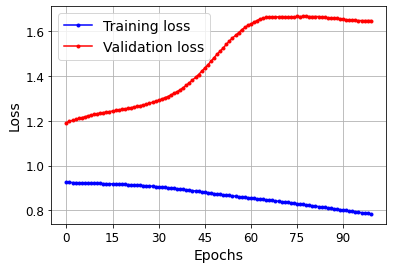

In [18]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)), loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)), val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    # plt.axis([1, len(history.epoch), 0.1, 0.15])
    # plt.axis([1, len(history.epoch), min(history.history["val_loss"]), max(history.history["val_loss"])])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [20]:
# Forecasting en conjunto de prueba
X_test_, y_test_ = split_sequence(X_test, n_steps_in_d, n_steps_out_d)
y_test = scaler.inverse_transform(y_test_)

print(X_test_.shape)
print(y_test.shape)

(5, 6)
(5, 2)


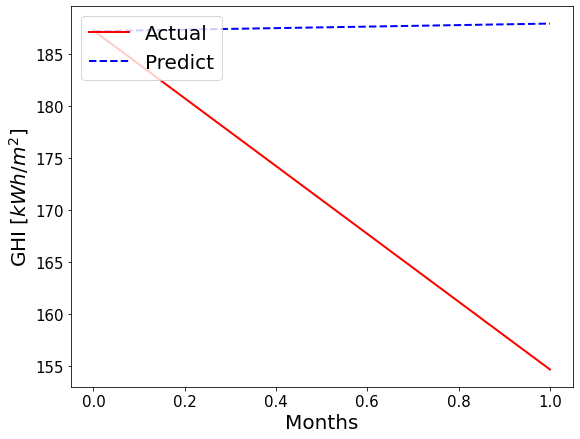

Root mean square error:  23.565299373109394
Mean absolute error:  16.69658923952383
R-Squared:  -1.0821034459227246


In [24]:
predict = 4
x_input = X_test_[predict].reshape((1, n_steps_in_d, n_features))
yhat_norm_d = model_d.predict(x_input, verbose=0)
yhat_d = scaler.inverse_transform(yhat_norm_d)
yhat_d = yhat_d[0]

var = scaler.inverse_transform(X_test)
actual = y_test[predict]
prev = var[predict-6:predict]
prev = np.hstack((prev,actual))

time = np.arange(24*7)
plt.rcParams['figure.figsize'] = (9, 7)
plt.plot(prev,'r',  label='Actual', linewidth=2)
plt.plot( yhat_d.ravel(),'b--',  label='Predict', linewidth=2)
plt.legend(loc='upper left', fontsize=20)
plt.xlabel("Months", fontsize=20)
plt.ylabel("GHI $[kWh/m^2]$", fontsize=20)
plt.yticks(size=15)
plt.xticks(size=15)
# plt.savefig('Figuras_Informe/predic_1_day_01012012.png', format='png', dpi=300)
plt.show() 

rmse = np.sqrt(mean_squared_error(actual, yhat_d))
mae = mean_absolute_error(actual, yhat_d)
r2 = r2_score(actual, yhat_d)

print('Root mean square error: ', rmse)
print('Mean absolute error: ', mae)
print('R-Squared: ', r2)